# MBAN 6400 Group Project(A)

In [10]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Katherine testing 

In [11]:
# read data
cc_data = pd.read_csv('credit_card.csv')
cc_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.4,0.00,0.17,0.00,0.08,0.00,0.0,2.0,1000.0,201.80,139.51,0.00,12.0
1,C10002,3202.47,0.91,0.00,0.00,0.0,6442.95,0.00,0.00,0.00,0.25,4.0,0.0,7000.0,4103.03,1072.34,0.22,12.0
2,C10003,2495.15,1.00,773.17,773.17,0.0,0.00,1.00,1.00,0.00,0.00,0.0,12.0,7500.0,622.07,627.28,0.00,12.0
3,C10004,1666.67,0.64,1499.00,1499.00,0.0,205.79,0.08,0.08,0.00,0.08,1.0,1.0,7500.0,0.00,NaN,0.00,12.0
4,C10005,817.71,1.00,16.00,16.00,0.0,0.00,0.08,0.08,0.00,0.00,0.0,1.0,1200.0,678.33,244.79,0.00,12.0


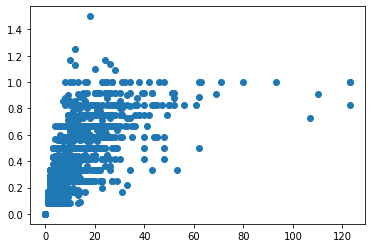

In [12]:
plt.scatter(cc_data.CASH_ADVANCE_TRX,cc_data.CASH_ADVANCE_FREQUENCY)

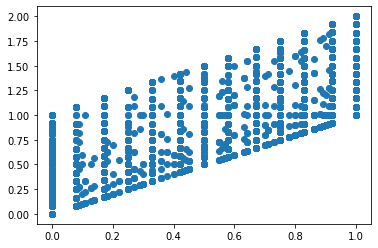

In [13]:
plt.scatter(cc_data.PURCHASES_INSTALLMENTS_FREQUENCY,cc_data.ONEOFF_PURCHASES_FREQUENCY+cc_data.PURCHASES_INSTALLMENTS_FREQUENCY)

In [14]:
# nulll value check
cc_data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [15]:
# data information
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

## Missing Value imputation

In [16]:
# payments = 0 and MINIMUM_PAYMENTS = NaN, assign MINIMUM_PAYMENTS to 0, else assign to nan
# drop the row where CREDIT_LIMIT is missing
values = cc_data[(cc_data['PAYMENTS']==0)]['MINIMUM_PAYMENTS'].isna().map({False: np.nan, True: 0})
cc_data['MINIMUM_PAYMENTS'] = cc_data['MINIMUM_PAYMENTS'].fillna(values)
cc_data = cc_data.dropna(subset=['CREDIT_LIMIT'])

In [17]:
# assign all other null value in MINIMUM_PAYMENTS as average value in the column
cc_data['MINIMUM_PAYMENTS'].fillna(cc_data['MINIMUM_PAYMENTS'].mean(),inplace=True)

In [18]:
X = cc_data.drop(columns = ['CUST_ID'])
# define min max scaler
scaler = MinMaxScaler()
# transform data
X_scaled = scaler.fit_transform(X)


## Clustering

### K-means Clustering

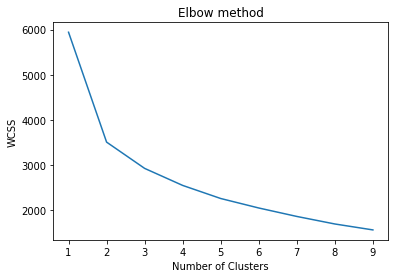

In [19]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(X_scaled) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


### Silhouette validation

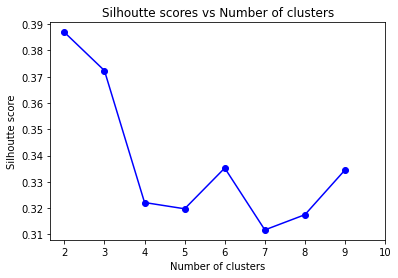

In [20]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_models[1:9]]
plt.plot(range(2,10), silhoutte_scores, "bo-")
plt.xticks([2, 3, 4,5,6,7,8,9,10])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()
